In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
import numpy as np
import json
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
import xgboost as xgb

In [0]:
# Importing the dataset
df = pd.read_json('/content/gdrive/My Drive/News_Category_Dataset.json', lines=True)

In [28]:
df.to_csv()
df.head()

,authors,category,date,headline,link,short_description
0,Melissa Jeltsen,CRIME,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.
2,Ron Dicker,ENTERTAINMENT,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...
3,Ron Dicker,ENTERTAINMENT,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...
4,Ron Dicker,ENTERTAINMENT,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ..."


In [0]:
# Drop unnecessary column
df = df.drop(['authors', 'date', 'link'], axis=1)

In [0]:
# Concatenate to both headline and short_description column
# because it is better to have single bag of words rather than two bag of words for each column
df['news'] = df['headline'] + "." + df['short_description']

# now drop both columns
df = df.drop(['short_description', 'headline'], axis = 1)

In [31]:
df.head()

,category,news
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 5...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...


In [32]:
# inspect the amount of each type of news category
df['category'].value_counts()

POLITICS          32739
ENTERTAINMENT     14257
HEALTHY LIVING     6694
QUEER VOICES       4995
BUSINESS           4254
SPORTS             4167
COMEDY             3971
PARENTS            3955
BLACK VOICES       3858
THE WORLDPOST      3664
WOMEN              3490
CRIME              2893
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
IMPACT             2602
WORLDPOST          2579
RELIGION           2556
STYLE              2254
WORLD NEWS         2177
TRAVEL             2145
TASTE              2096
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
SCIENCE            1381
ARTS & CULTURE     1339
TECH               1231
COLLEGE            1144
LATINO VOICES      1129
EDUCATION          1004
Name: category, dtype: int64

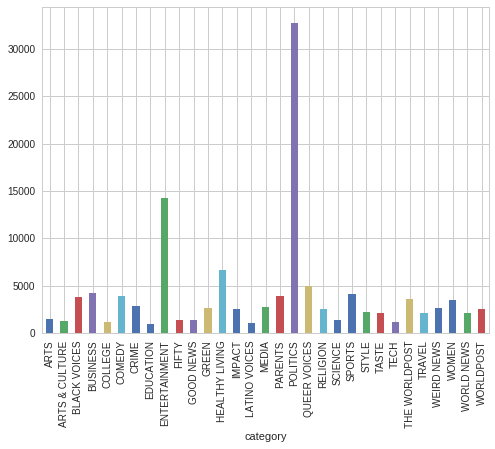

In [33]:
# Category Visualization
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('category').news.count().plot.bar(ylim=0)
plt.show()


In [34]:
# after concatenation
df['news'][0]

'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV.She left her husband. He killed their children. Just another day in America.'

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124989 entries, 0 to 124988
Data columns (total 2 columns):
category    124989 non-null object
news        124989 non-null object
dtypes: object(2)
memory usage: 7.9+ MB


In [36]:
# Cleaning the texts
from tqdm import tqdm
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
corpus = []
for i in tqdm(range(0, 124989)):
    desc = re.sub('[^a-zA-Z]', ' ', df['news'][i])
    desc = desc.lower()
    desc = desc.split()
    ps = PorterStemmer()
    desc = [ps.stem(word) for word in desc if not word in set(stopwords.words('english'))]
    desc = ' '.join(desc)
    corpus.append(desc)

  0%|          | 19/124989 [00:00<11:10, 186.39it/s]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


100%|██████████| 124989/124989 [11:59<00:00, 173.62it/s]


In [37]:
# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X_counts = cv.fit_transform(corpus)
X_counts.shape

(124989, 41814)

In [38]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)
Y = df.iloc[:, 0].values
X_tfidf.shape

(124989, 41814)

In [0]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_tfidf, Y, test_size = 0.20, random_state = 0)

In [0]:
# Hyperparameter Tuning and fitting the classifier model

from time import time
from operator import itemgetter
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_digits

#build a classifier
clf = SGDClassifier()

# Utility function to report best scores
def report(grid_scores, n_top=3):
    ts = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(ts):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
            score.mean_validation_score,
            np.std(score.cv_validation_scores)))
        print("Parameters: {0}\n".format(score.parameters))


In [44]:
# use a full grid over all parameters
param_grid = {"max_iter": [1, 5, 10],
              "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
              "penalty": ["none", "l1", "l2"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=-1)
start = time()
grid_search.fit(X_test, Y_test)

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_iter': [1, 5, 10], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['none', 'l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [45]:
'''print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_)))
report(grid_search.cv_results_)'''
#scores = grid_search.cv_results_['mean_test_score'].reshape(-1, 3).T
sorted(grid_search.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_alpha',
 'param_max_iter',
 'param_penalty',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'split3_test_score',
 'split3_train_score',
 'split4_test_score',
 'split4_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

In [0]:
# Predicting the Test set results
Y_pred = grid_search.predict(X_test)

In [47]:
# result
np.mean(Y_pred == Y_test)

0.833906712537003

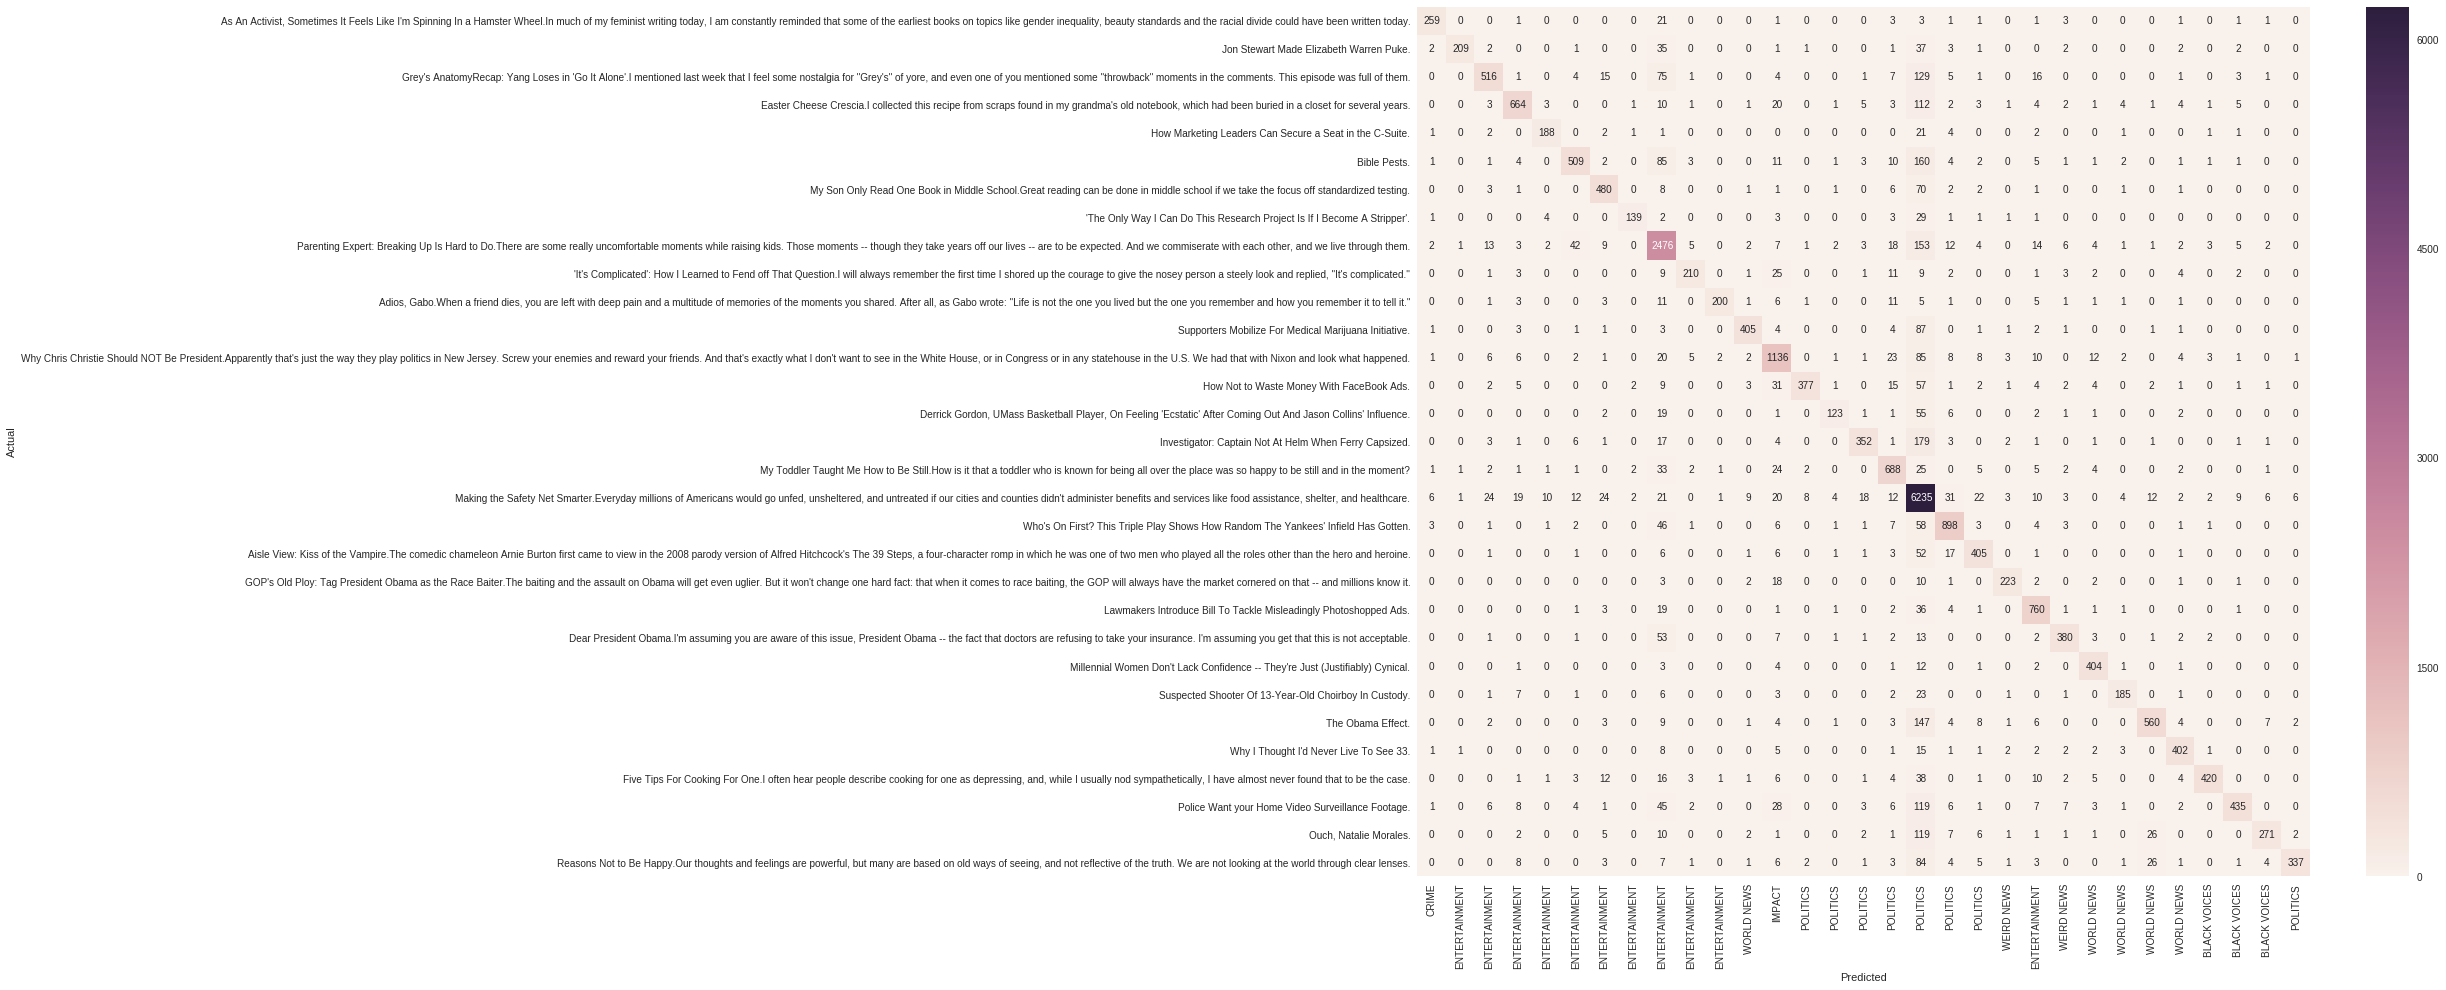

In [51]:
# confusion matrix
conf_mat = confusion_matrix(Y_test, Y_pred)
fig, ax = plt.subplots(figsize=(20,16))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=df['category'].values, yticklabels=df['news'].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [50]:
#the classification report for each class
from sklearn import metrics
print(metrics.classification_report(Y_test, Y_pred, target_names=df['category'].unique()))

                precision    recall  f1-score   support

         CRIME       0.93      0.87      0.90       297
 ENTERTAINMENT       0.98      0.70      0.82       299
    WORLD NEWS       0.87      0.66      0.75       780
        IMPACT       0.89      0.78      0.83       852
      POLITICS       0.90      0.84      0.86       225
    WEIRD NEWS       0.86      0.63      0.73       808
  BLACK VOICES       0.85      0.83      0.84       578
         WOMEN       0.95      0.75      0.84       185
        COMEDY       0.80      0.89      0.84      2793
  QUEER VOICES       0.90      0.74      0.81       284
        SPORTS       0.98      0.79      0.88       252
      BUSINESS       0.94      0.78      0.85       516
        TRAVEL       0.81      0.85      0.83      1343
         MEDIA       0.96      0.72      0.83       521
          TECH       0.88      0.57      0.70       214
      RELIGION       0.89      0.61      0.73       574
       SCIENCE       0.81      0.86      0.83  